In [1]:
import numpy as np
import json
from scipy.io.wavfile import read
import processing
import matplotlib.pyplot as plt
import json
import IPython.display as ipd
from scipy.signal import savgol_filter
import util
import quickPlayer

In [2]:
scores = np.load("results/scores-SFHA-MC.npy",allow_pickle = True)

In [3]:
soundDir = "musiccritic_cropped/"
annotationDir = soundDir + "Annotations/"
solofiles,chordfiles = util.separateFiles(soundDir,"mc")

In [33]:
i = 20                   
filename = scores[i][0]
print(filename)
filename in chordfiles

231_recording-0-2019-03-20T10-26-29-251Z-0


True

In [31]:
# load file and onset preds
filedir = annotationDir + filename
audio_filename = soundDir + filename+ ".wav"
fs, x = read(audio_filename)
x = x/np.max(np.abs(x))
gt = scores[i][2]*fs
pred = scores[i][3]*fs

# transform
M = [4095,2047]
N = 4096
H = 128
B = [[0,int(2000*N/fs)],[int(2000*N/fs),int(fs/2)]]
params= (M,N,H,B)
mX,pX = processing.fTransform(x,fs,params)

# sf, rms calculation and filtering
sf,sfn = processing.MRSF(mX,B=[0,int(2000*N/fs)],a=51,b=3,size=0.1)
rms = np.sum(mX,axis=1)
rms = rms-np.mean(rms)
rms = rms/np.max(rms)
rms = savgol_filter(rms,3,1)

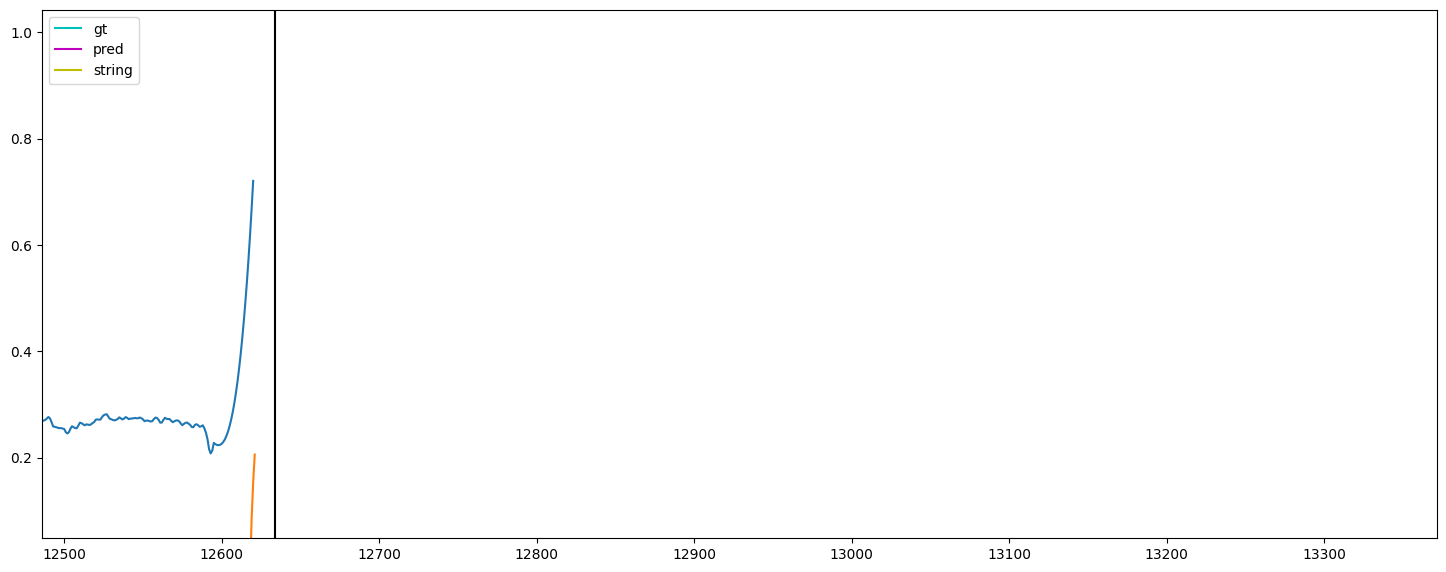

In [32]:
# from the predicted onset locations, we calculate chords' rise area using filtered rms, 
# if they are not too close, each string's onset inside the area predicted 

rise_areas = []
window = 100
strings = np.array([])
for o in pred:
    o = int(o/128)
    lw = np.min((window,o))
    rw = np.min((window,mX.shape[0]-o))
    rise_start = np.argmax(np.convolve(rms[o-lw+1:o+30]-rms[o-lw:o+29],np.ones(30))[30:])
    rise_end = np.argmax(np.convolve(rms[o+1:o+rw]-rms[o:o+rw-1],np.ones(30)*-1)[30:])
    rise_areas.append([o-lw+rise_start,o+rise_end])
    
    strings = np.append(strings,(o-lw+rise_start+processing.candidSelection(rms[o-lw+rise_start:o+rise_end+10],t=0.01,hw=3)))
    
quickPlayer.quickPlayer(audio_filename,[sf,rms],[gt,pred,strings*128],["gt","pred","string"],h=128,onlyValues=True,regions=rise_areas)